<a href="https://colab.research.google.com/github/sychun/colab/blob/master/h_nn_rnn_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip
# !rm -f jena_climate_2009_2016.csv.zip
# !mkdir data-files
# !mkdir data-files/jena_climate
# !mv jena_climate_2009_2016.csv data-files/jena_climate

In [3]:
import os

data_dir = './data-files/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [4]:
lines[:3]

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60']

In [5]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values


In [6]:
float_data[0].shape, float_data[0]

((14,), array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02]))

In [7]:
from matplotlib import pyplot as plt

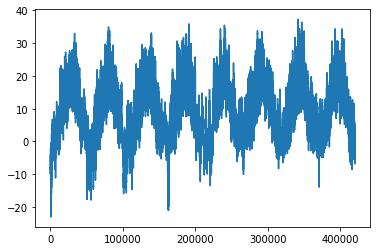

In [8]:
temp = float_data[:, 1] # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

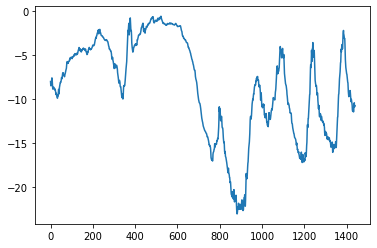

In [9]:
plt.plot(range(1440), temp[:1440])

In [10]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [11]:
# 참고 
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler().fit(float_data2[:200000])
# scaled_float_data2 = scaler.transform(float_data2)

In [12]:
float_data.shape

(420551, 14)

In [13]:
# 10일간의 데이터를 1시간 단위로 샘플링해서 시퀀스 생성 * 128 batch -> ( 128, 240, 14 )
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index)) # 1440 ~ 1440 + 128
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1])) # (128, 240, 14)
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows): # 0, 1440 / 1, 1441 / 2, 1442 / ...
            indices = range(rows[j] - lookback, rows[j], step) # 0, 6, 12, 18, ....
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [14]:
lookback = 1440
step = 6
delay = 144 # 현 싯점에서 하루 뒤
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [15]:
data = []
for i in range(10):
  data.append( next(train_gen))

In [16]:
data[0][0].shape, data[0][1].shape # 240은 순차적으로 이루어져야 함

((128, 240, 14), (128,))

In [17]:
### 여기까지는 데이터 준비

In [18]:
# 손실: (마지막 측정값(현재시간)) - 1일후 측정값)의 mae
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1] # 마지막 현재 시간의 온도
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method() # baseline 값을 확인하고, 다음을 진행해 보자

0.2897359729905486


In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(240, 14)))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1)) # 회귀이므로 항등함수

model.compile(loss='mae', optimizer='rmsprop')

history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 13s 25ms/step - loss: 1.5662 - val_loss: 1.0594
Epoch 2/20
500/500 [==============================] - 12s 23ms/step - loss: 0.5040 - val_loss: 0.3098
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2964 - val_loss: 0.3270
Epoch 4/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2690 - val_loss: 0.3066
Epoch 5/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2557 - val_loss: 0.3122
Epoch 6/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2466 - val_loss: 0.3047
Epoch 7/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2386 - val_loss: 0.3287
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2322 - val_loss: 0.3113
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2284 - val_loss: 0.3444
Epoch 10/20
500/500 [==============================] - 11s 23ms/step - loss: 0.223

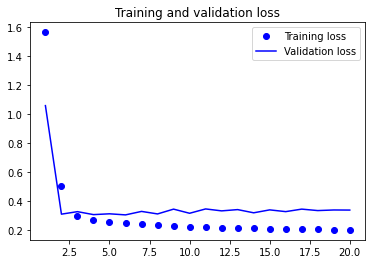

In [23]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
### 위 결과가 만족스럽지 못하므로 RNN GRU로 재 시도

In [26]:
model2 = keras.models.Sequential()
model2.add(keras.layers.GRU(32, input_shape=(None, 14)))
model2.add(keras.layers.Dense(1)) # 회귀이므로 항등함수

model2.compile(loss='mae', optimizer=keras.optimizers.RMSprop(learning_rate=0.001))

history = model2.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2973 - val_loss: 0.2715
Epoch 2/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2857 - val_loss: 0.2681
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2762 - val_loss: 0.2655
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2705 - val_loss: 0.2634
Epoch 5/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2657 - val_loss: 0.2718
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2599 - val_loss: 0.2614
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2575 - val_loss: 0.2685
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2518 - val_loss: 0.2718
Epoch 9/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2490 - val_loss: 0.2713
Epoch 10/20
500/500 [==============================] - 16s 32ms/step - loss: 0.244

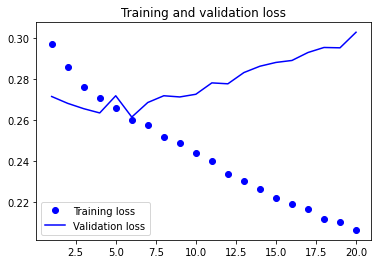

In [27]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()